In [1]:
import os
from pathlib import Path
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForConditionalGeneration, get_cosine_schedule_with_warmup
import requests
from datasets import load_from_disk
from accelerate import Accelerator
import torch
import spacy
import re
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sys
import numpy as np
import torch
import random
from evaluate import load
sys.path.append(str(Path.cwd().parent))

# set all seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils.dirutils import get_data_dir

In [3]:
MODEL_NAME = "microsoft/git-base"
PROCESSOR = AutoProcessor.from_pretrained(MODEL_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
OUTPUT_DIR = "microsoft_git-base_artgraph"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1 # choose according to your GPU memory (<= 64) we'll use gradient accumulation
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
DATASET = load_from_disk(get_data_dir() / "processed" / "captioning_dataset_augmented_processed")

In [5]:
DATASET["validation"][20]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=220x275>,
 'clip_score': 0.29621822988245694,
 'file_name': 'antonello-da-messina_st-jerome-in-his-study.jpg',
 'captions': ['St Jerome, a bearded man dressed in red, sitting at a desk and holding a book with a lion at his feet',
  'St Jerome, a bearded man dressed in red, sitting at an office and holding a book with a lion at his feet',
  'St Jerome, a bearded man dressed in red, sits at a desk holding a book with a lion at his feet']}

In [6]:
# on the fly image augmentation
augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=10),
])

def _transform_train(example_batch):
    images = [augment(x) for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]
    inputs = PROCESSOR(images=images, padding="max_length", return_tensors="pt")
    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs


def _transform_test(example_batch):
    # just compute the input_ids for all captions in example
    images = [x for x in example_batch["image"]]
    captions_list = [x for x in example_batch["captions"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]
    inputs_list = [
        PROCESSOR(images=image, text=captions, padding="max_length", return_tensors="pt")
        for image, captions in zip(images, captions_list)
    ]
    # from list of dicts to dict of lists
    inputs = {}
    for k in inputs_list[0].keys():
        inputs[k] = [x[k] if k != "pixel_values" else x[k].squeeze() for x in inputs_list]

    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs


DATASET["train"].set_transform(_transform_train)
DATASET["validation"].set_transform(_transform_test)

In [7]:
train_dataloader = DataLoader(DATASET["train"].select(range(10)), batch_size=1)
valid_dataloader = DataLoader(DATASET["validation"].select(range(10)), batch_size=2)

In [8]:
next(iter(train_dataloader))["pixel_values"]

tensor([[[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          ...,
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],

         [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          ...,
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],

         [[-1.4802, -1.4802, -1.4802,  ..., -1.4802, -1.4802, -1.4802],
          [-1.4802, -1.4802, -

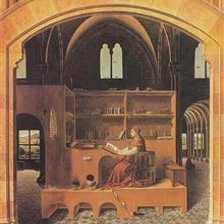

In [9]:
from PIL import Image
import numpy as np
from tqdm import tqdm

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (DATASET["validation"][20]["pixel_values"].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [10]:
print(MODEL.generation_config)

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 101,
  "eos_token_id": 102,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}



In [11]:
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

@torch.no_grad()
def compute_metrics():
    all_decoded_predictions, all_decoded_labels = [], []
    for batch in tqdm(valid_dataloader):
        labels = batch.pop("input_ids").to(DEVICE)
        pixel_values = batch.pop("pixel_values").to(DEVICE)

        generated_ids = MODEL.generate(pixel_values=pixel_values, max_length=50)
        decoded_labels = []
        for label_group in labels:
            decoded_labels.append(PROCESSOR.batch_decode(label_group, skip_special_tokens=True))
        decoded_predictions = PROCESSOR.batch_decode(generated_ids, skip_special_tokens=True)

        all_decoded_labels += decoded_labels
        all_decoded_predictions += decoded_predictions

    bleu1_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels, max_order=1)
    bleu4_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    rouge_score = rouge.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    meteor_score = meteor.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    return {
        "bleu1_score": bleu1_score,
        "bleu4_score": bleu4_score,
        "rouge_score": rouge_score,
        "meteor_score": meteor_score
    }

[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nico/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
import torch
from torch.nn import functional as nnf

# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-7)
EPOCHS = 10
IDEAL_BATCH_SIZE = 64
GRADIENT_ACCUMULATION_STEPS = IDEAL_BATCH_SIZE // BATCH_SIZE
optimizer = torch.optim.SGD(MODEL.parameters(), lr=4.5e-7)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=(len(DATASET["train"]) // IDEAL_BATCH_SIZE) * EPOCHS)
MODEL.to(DEVICE)
# MODEL.gradient_checkpointing_enable()
# accelerator = Accelerator(mixed_precision="fp16")
# MODEL, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(
#     MODEL, optimizer, train_dataloader, valid_dataloader
# )

num_image_tokens = MODEL.git.encoder.layer[0].attention.self.image_patch_tokens

In [13]:
epoch = 0
while epoch < EPOCHS:
  MODEL.train(True)
  print("Epoch:", epoch)
  running_loss = 0.0
  for step, batch in enumerate(tqdm(train_dataloader), start=1):
    input_ids = batch.pop("input_ids").to(DEVICE)
    labels = input_ids
    pixel_values = batch.pop("pixel_values").to(DEVICE)
    attention_mask = batch.pop("attention_mask").to(DEVICE)
    clip_weights = batch.pop("clip_score").to(DEVICE)
    clip_weights = (clip_weights * 8) - 1/5

    outputs = MODEL(input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask)
    logits = outputs.logits

    # weighted loss
    shifted_logits = logits[:, num_image_tokens:-1, :].contiguous()
    labels = labels[:, 1:].contiguous()
    shifted_logits = shifted_logits.permute(0, 2, 1)
    losses = nnf.cross_entropy(shifted_logits, labels, ignore_index=0, reduction="none")
    # mean for each row, but ignore 0s
    losses = losses.sum(dim=1) / (labels != 0).sum(dim=1)
    weighted_losses = losses * clip_weights
    loss = weighted_losses.mean() / GRADIENT_ACCUMULATION_STEPS
    running_loss += loss.item()
    print("Loss:", loss.item())

    # accelerator.backward(loss)
    loss.backward()

    if step % GRADIENT_ACCUMULATION_STEPS == 0:
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
  
  MODEL.train(False)
  avg_loss = running_loss / (len(DATASET["train"]) // IDEAL_BATCH_SIZE)
  metrics = compute_metrics()
  metrics["loss"] = avg_loss
  with open(os.path.join(OUTPUT_DIR, f"{epoch}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
  print("Loss:", avg_loss)
  torch.save({
        'epoch': epoch,
        'model_state_dict': MODEL.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
  }, os.path.join(OUTPUT_DIR, f"{epoch}.pt"))
  epoch += 1

Epoch: 0


  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'input_ids'

In [ ]:
MODEL.generate(pixel_values=next(iter(train_dataloader))["pixel_values"].to(DEVICE), max_length=50)